In [2]:
from numpy import asarray
import numpy as np

import os
import cv2
import glob
import imagehash
from PIL import Image

import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout
from keras import optimizers
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from pickle import dump


In [7]:
images = sorted(glob.glob("./Images/*.jpg"))
masks = sorted(glob.glob("./Masks/*.jpg"))

print(len(images), len(masks))

2841 2841


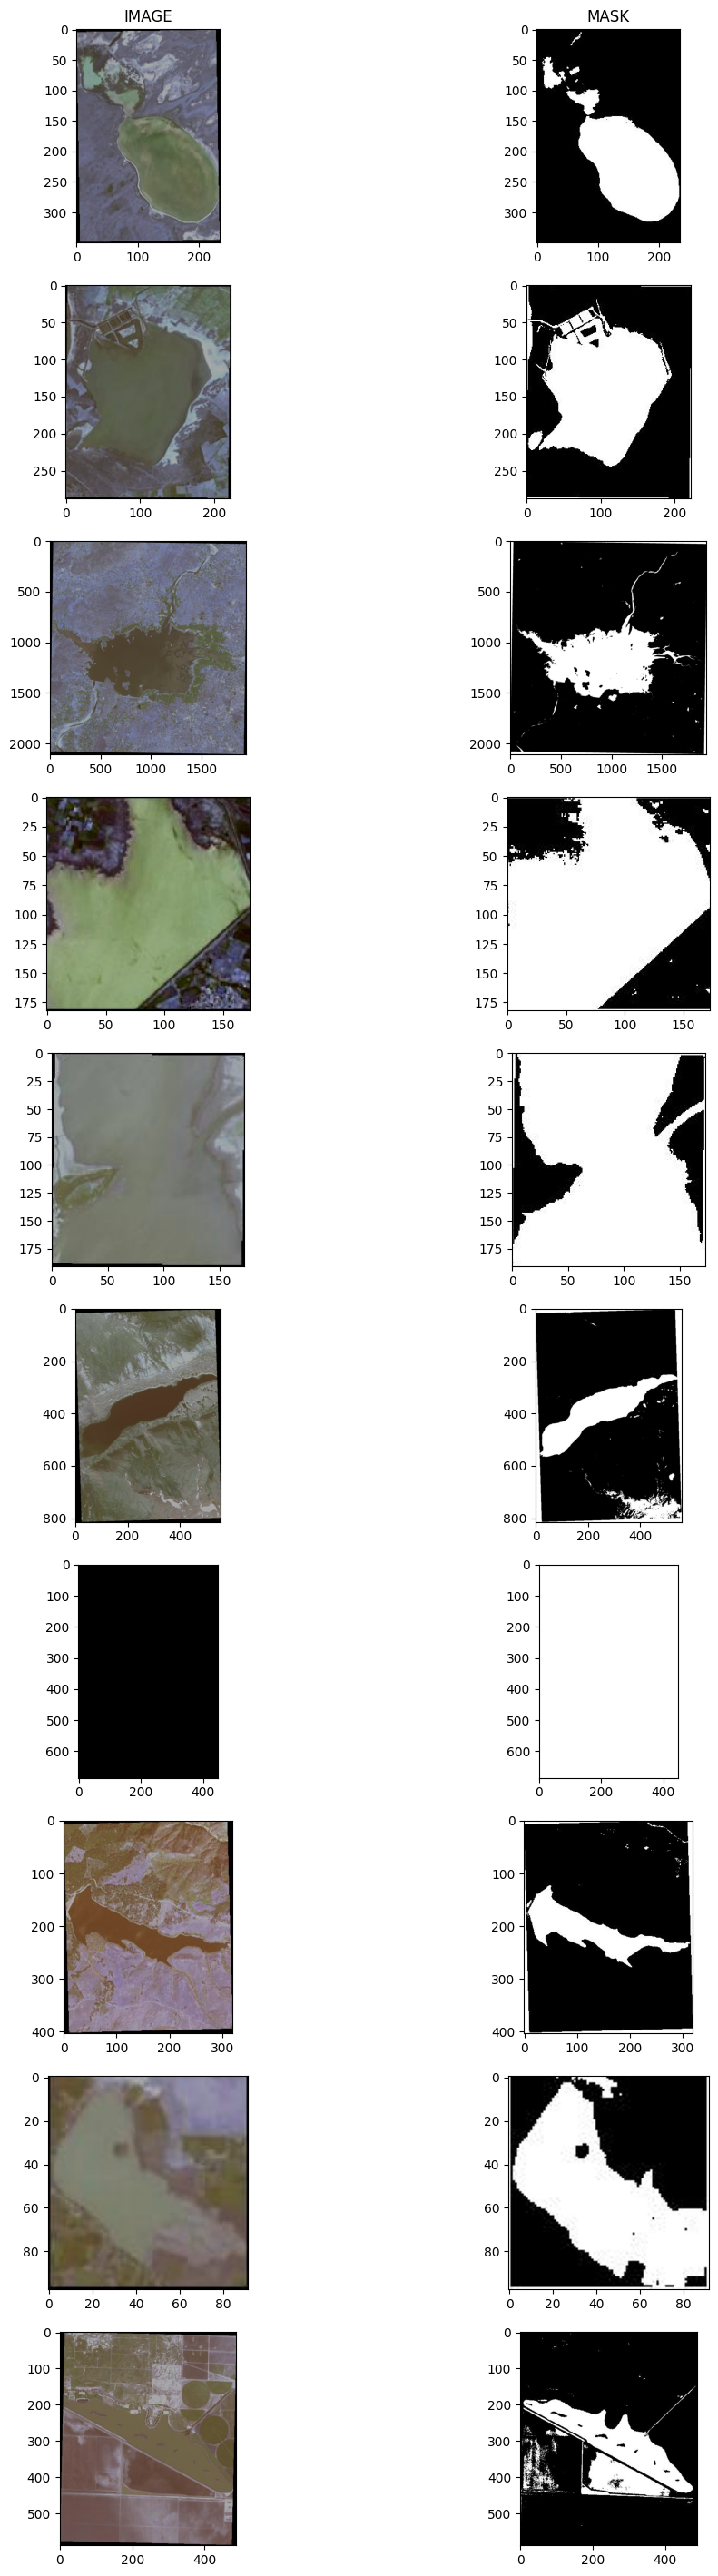

In [8]:
f, axr = plt.subplots(10,2, figsize=(12,36))
for i in range(10):
    idx = np.random.randint(0, len(images))
    original = cv2.imread(images[idx])
    mask = cv2.imread(masks[idx])
    axr[i,0].imshow(original)
    axr[i,1].imshow(mask)
    i +=1
    axr[0, 0].set_title("IMAGE")
    axr[0, 1].set_title("MASK")

In [9]:
# calculating statistics of the image dimensions
dimen_img_list = []

for img in images:
    img = cv2.imread(img, cv2.COLOR_BGR2RGB)
    dimen_img = img.shape[:2]
    dimen_img_list.append(dimen_img)

# converting the list to numpy array 
dimen_img_array = np.array(dimen_img_list)  

In [10]:
# Calculating statistics of the image dimensions
print("Statistics of image dimensions:")
print("Minimum width:", np.min(dimen_img_array[:, 1]))
print("Maximum width:", np.max(dimen_img_array[:, 1]))
print("Mean width:", np.mean(dimen_img_array[:, 1]))
print("Median width:", np.median(dimen_img_array[:, 1]))
print("Standard deviation of width:", np.std(dimen_img_array[:, 1]))
print("Minimum height:", np.min(dimen_img_array[:, 0]))
print("Maximum height:", np.max(dimen_img_array[:, 0]))
print("Mean height:", np.mean(dimen_img_array[:, 0]))
print("Median height:", np.median(dimen_img_array[:, 0]))
print("Standard deviation of height:", np.std(dimen_img_array[:, 0]))

Statistics of image dimensions:
Minimum width: 5
Maximum width: 5640
Mean width: 445.2555438225977
Median width: 259.0
Standard deviation of width: 553.6202774845702
Minimum height: 7
Maximum height: 7093
Mean height: 560.6652587117212
Median height: 334.0
Standard deviation of height: 688.890393959364


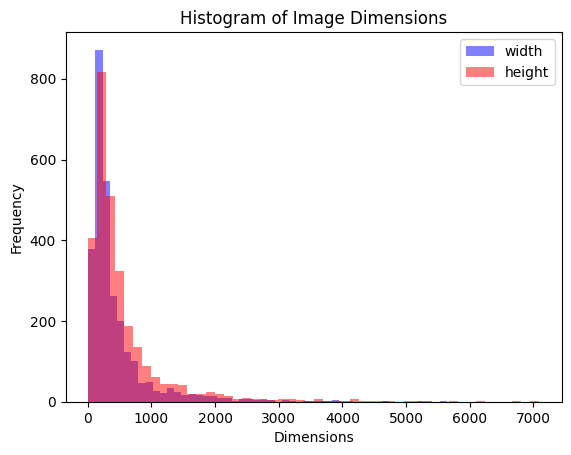

In [14]:
# Plotting the histogram for better analysis
plt.hist(dimen_img_array[:, 1], bins=50, alpha=0.5, color='blue', label='width')
plt.hist(dimen_img_array[:, 0], bins=50, alpha=0.5, color='red', label='height')
plt.xlabel('Dimensions')
plt.ylabel('Frequency')
plt.title('Histogram of Image Dimensions')
plt.legend()
plt.show()

In [16]:
# a) Data Cleaning

#Detecting and removing duplicate images and masks
hashes = {}
to_remove = []

for file in images:
    if file.endswith('.jpg'):
        with open(file, 'rb') as f:
            img = Image.open(f)
            # Compute the hash value for the image
            h = imagehash.phash(img)
            # Checking if the hash value already exists in the dictionary
            if h in hashes:
                print(f'Duplicate image found: {file} and {hashes[h]}')
                to_remove.append(file)
                mask_file = os.path.join("./Masks/", os.path.basename(file))
                to_remove.append(mask_file)
            else:
                hashes[h] = file

Duplicate image found: ./Images\water_body_1244.jpg and ./Images\water_body_1023.jpg
Duplicate image found: ./Images\water_body_1333.jpg and ./Images\water_body_1023.jpg
Duplicate image found: ./Images\water_body_1552.jpg and ./Images\water_body_1023.jpg
Duplicate image found: ./Images\water_body_1619.jpg and ./Images\water_body_1023.jpg
Duplicate image found: ./Images\water_body_1659.jpg and ./Images\water_body_1023.jpg
Duplicate image found: ./Images\water_body_2312.jpg and ./Images\water_body_1023.jpg
Duplicate image found: ./Images\water_body_608.jpg and ./Images\water_body_1023.jpg
Duplicate image found: ./Images\water_body_636.jpg and ./Images\water_body_1023.jpg
Duplicate image found: ./Images\water_body_7052.jpg and ./Images\water_body_1023.jpg
Duplicate image found: ./Images\water_body_7202.jpg and ./Images\water_body_1023.jpg
Duplicate image found: ./Images\water_body_778.jpg and ./Images\water_body_1023.jpg
Duplicate image found: ./Images\water_body_810.jpg and ./Images\wate

In [17]:
# Create a new list of filenames that excludes the duplicates
new_images = [file for file in images if file not in to_remove]
new_masks = [os.path.join("./Masks/", os.path.basename(file)) for file in new_images]
print(len(new_images), len(new_masks))

2824 2824


In [18]:
# Loading, filtering blank and abnormal size images and masks, and resize them to the median values or larger

min_size = 32
df_images = []
df_masks = []

height = width = 300

for image, mask in zip(new_images, new_masks):
    #cv2.imread reads image in BGR, we need to convert it back to the standard mode RGB 
    n = cv2.imread(image, cv2.COLOR_BGR2RGB)
    m = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    
    # Checking if the image has size > min_size and is entirely black or white 
    if min(n.shape[:2]) > min_size and ((m != 0).any() and (m != 255).any()):
        n = cv2.resize(n, (height, width)) # resize to median values or larger 
        df_images.append(n)
        m = cv2.resize(m, (height, width)) # resize to median values or larger
        df_masks.append(m)

# Converting image into array of pixels
df_images = asarray(df_images)

# Converting mask into array of pixels
df_masks = asarray(df_masks)

print(len(df_images), len(df_masks))

2698 2698


In [19]:
# b) Splitting data into train and test sets

X = df_images
y = df_masks

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.015, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(2023, 300, 300, 3) (2023, 300, 300) (664, 300, 300, 3) (664, 300, 300) (11, 300, 300, 3) (11, 300, 300)


In [20]:
# Flattening images and converting data from numpy array to float type
X_train = X_train.reshape(X_train.shape[0], height, width, 3).astype('float32')
X_test = X_test.reshape(X_test.shape[0], height, width, 3).astype('float32')
X_val = X_val.reshape(X_val.shape[0], height, width, 3).astype('float32')
y_train = y_train.reshape(y_train.shape[0], height, width).astype('float32')
y_test = y_test.reshape(y_test.shape[0], height, width).astype('float32')
y_val = y_val.reshape(y_val.shape[0], height, width).astype('float32')

In [21]:
# normalizing inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255
y_train = y_train / 255
y_test = y_test / 255
y_val = y_val / 255

In [22]:
print(X_train.shape, X_test.shape)

(2023, 300, 300, 3) (664, 300, 300, 3)


In [23]:
input_shape = (height, width, 3)

def base_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoding layers
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoding layers
    up3 = layers.UpSampling2D(size=(2, 2))(pool2)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
    conv4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(up5)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Building the model
model = base_model(input_shape)

# Reshaping target data to match output shape of the model
y_train = y_train.reshape(-1, height, width, 1)
y_test = y_test.reshape(-1, height, width, 1)

In [24]:
# Defining a callback for early stopping if the validation loss does not improve for 10 consecutive 
# epochs (patience=4).
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

In [25]:
# Fitting the model to train and test sets
history = model.fit(X_train, y_train, batch_size=64, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.6110 - loss: 0.5421 - val_accuracy: 0.6625 - val_loss: 0.4734
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.6535 - loss: 0.4719 - val_accuracy: 0.6611 - val_loss: 0.4474
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.6653 - loss: 0.4402 - val_accuracy: 0.6744 - val_loss: 0.4214
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.6715 - loss: 0.4282 - val_accuracy: 0.6934 - val_loss: 0.3990
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.6836 - loss: 0.4123 - val_accuracy: 0.6631 - val_loss: 0.4164
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.6926 - loss: 0.3960 - val_accuracy: 0.6750 - val_loss: 0.4258
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.6847 - loss: 0.4086 - val_accuracy: 0.6943 - val_loss: 0.3938
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.6902 - loss: 0.4021 - val_accuracy: 0.6954 - v

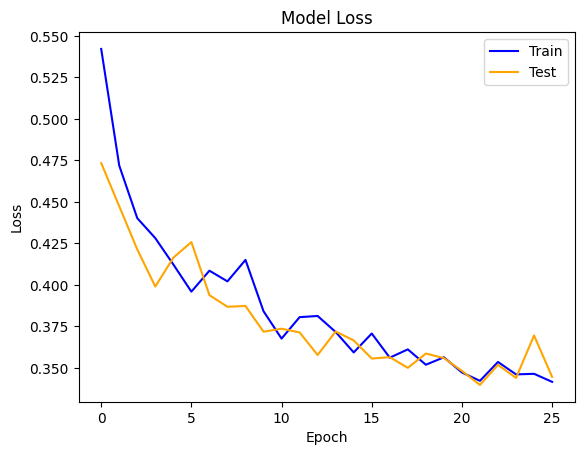

In [26]:
# Plotting diagnostic learning curves
plt.title('Model Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc ="upper right")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
11


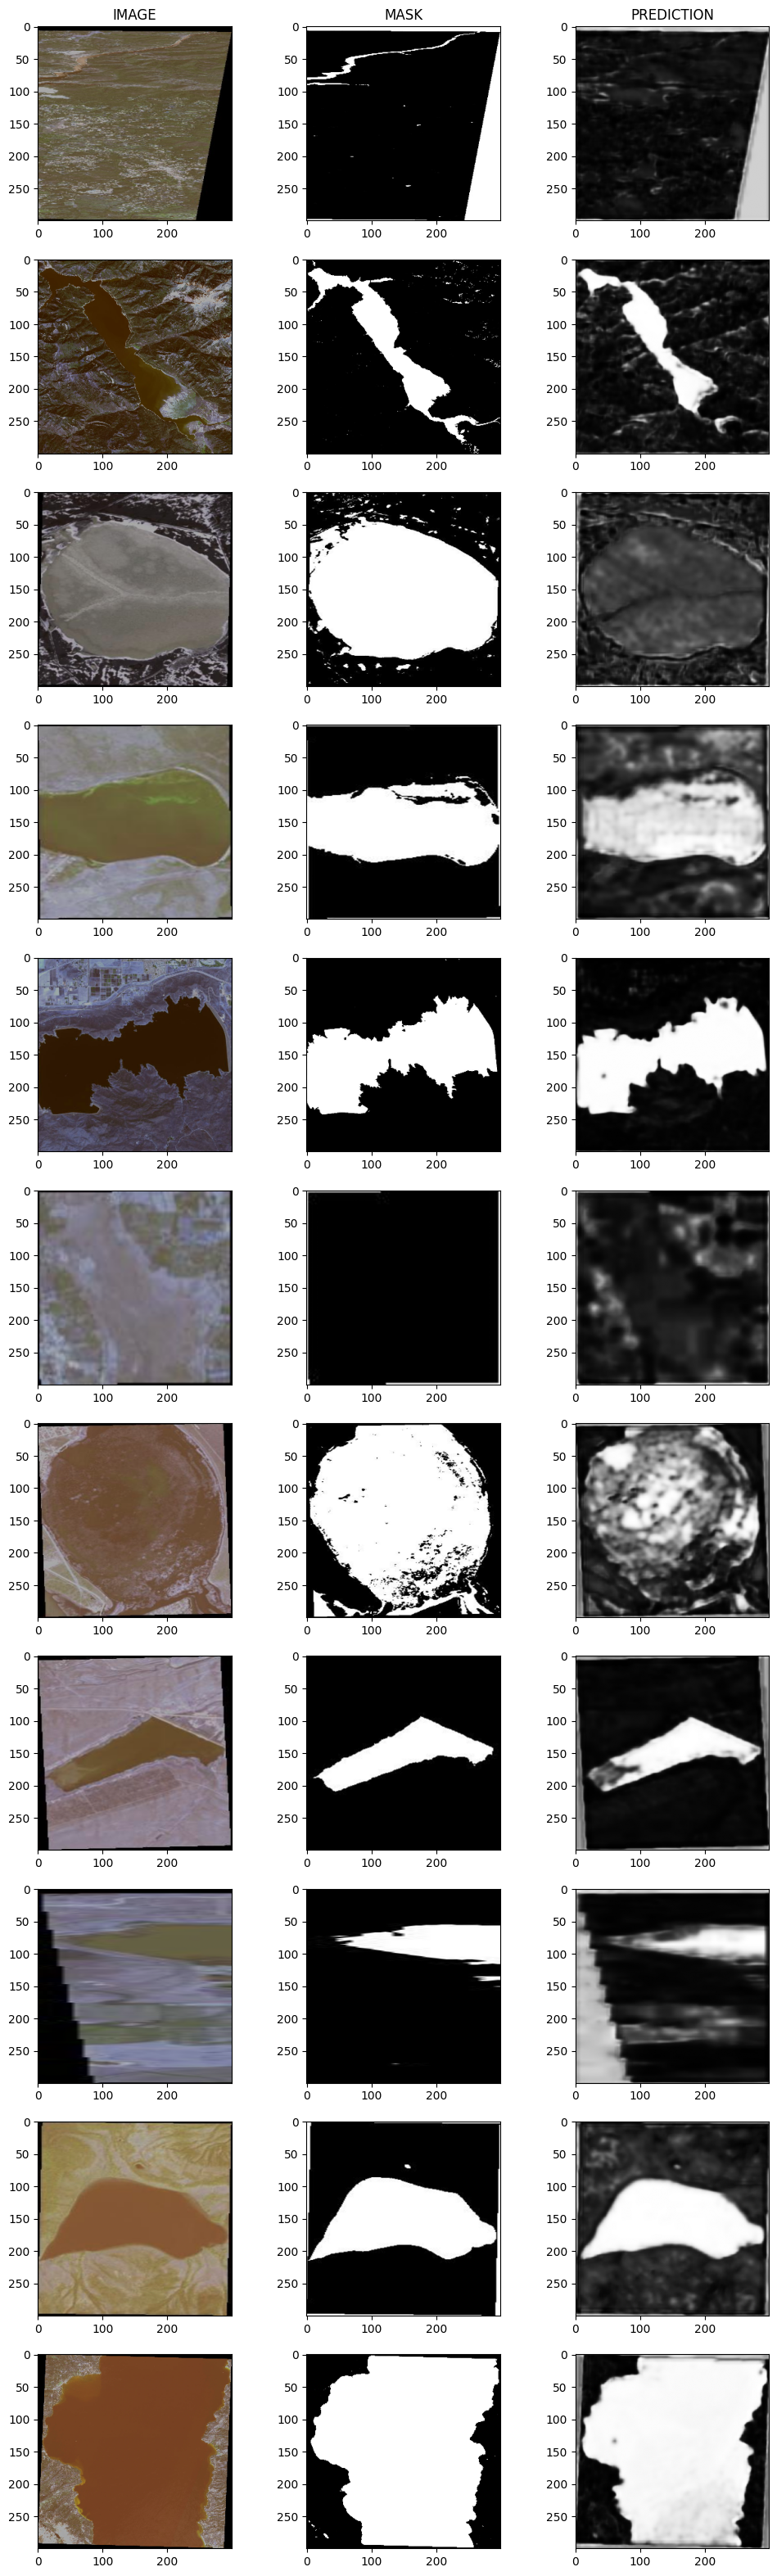

In [ ]:
# a) Predictions on validation data
Pred = model.predict(X_val)


# Plot original and predicted images
fig, ax = plt.subplots(11, 3, figsize=(12,40))
for i in range(11):
    orig = X_val[i]
    msk = y_val[i]
    pred = Pred[i]
    ax[i,0].imshow(orig)
    ax[i,1].imshow(msk, cmap='gray')
    ax[i,2].imshow(pred, cmap='gray')
    i +=1
    ax[0, 0].set_title("IMAGE")
    ax[0, 1].set_title("MASK")
    ax[0, 2].set_title("PREDICTION")

In [28]:
# b) Saving the model for later use

# saving the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))